In [85]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
def go(N, lambd, dim):
    
    particles = []
    R = 1
    t = 1 - 2 * R / lambd
    for i in range(N):
        # Generate random particle
        (x, y) = np.random.rand(2) * (dim - 2 * R)

        contact = [x, y, R]
        interact_p = None
        nearby = np.zeros([0, 3])
        for p in particles:
            sq_dist = ((x - p[0]) ** 2 + (y - p[1]) ** 2)
            if sq_dist <= (lambd * R) ** 2:
                b = (lambd * R) ** 2 - sq_dist
                z_0 = p[2] + b ** 0.5
                if z_0 > contact[2]:
                    contact[2] = z_0
                    interact_p = p

        [x, y, z] = contact          
        if interact_p:
            (a, b, c) = interact_p
            pos = (x+(a-x)*t, y+(b-y)*t, z+(c-z)*t)
        else:
            pos = contact

        particles.append(pos)
        
    return np.array(particles)
                

In [120]:
p = go(1000, 15, 100)

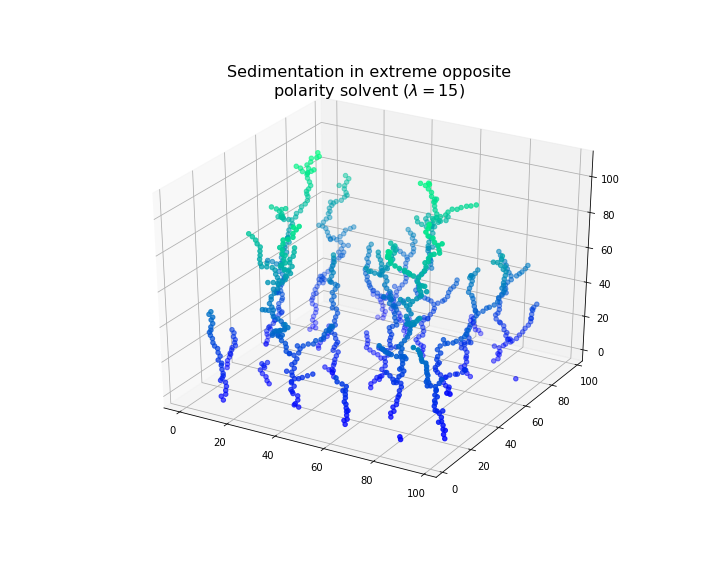

In [119]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[:,0], p[:,1], p[:,2], c = p[:,2], cmap = 'winter')
plt.title('Sedimentation in extreme opposite\npolarity solvent ($\lambda = 15$)', fontsize=16)
plt.savefig('lambda_15', dpi = 800)
plt.show()

In [44]:
l2_densities = []
dim = 25
N = 500
max_height = 20
l = 2
for i in range(100):
    p = go(N, l, dim)
    mask = p[:,2] < max_height - 1
    l2_densities.append(4 * sum(mask) * np.pi / (3 * (dim ** 2 - 4 + np.pi) * max_height))

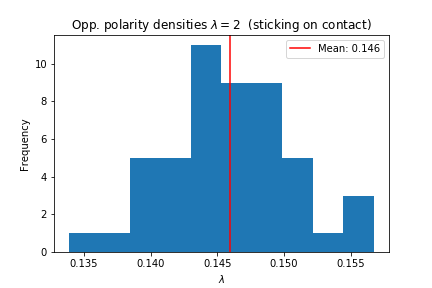

In [115]:
plt.hist(l2_densities)
plt.axvline(np.mean(l2_densities), color='red', linewidth=1.5, label='Mean: {}'.format(round(np.mean(l2_densities), 3)))
plt.legend(loc='upper right')
plt.xlabel("$\lambda$")
plt.ylabel("Frequency")
plt.title("Opp. polarity densities $\lambda=2$  (sticking on contact)")
plt.savefig('lambda_2', dpi = 800)
plt.show()

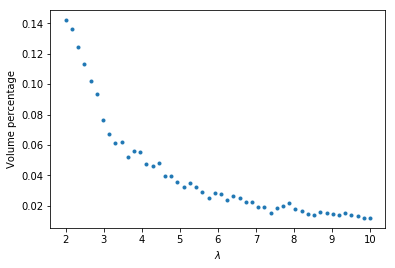

In [42]:
%matplotlib inline
densities = []
dim = 25
N = 500
max_height = 20
pts = np.linspace(2, 10, 50)
for l in pts:
    p = go(N, l, dim)
    mask = p[:,2] < max_height - 1
    densities.append(4 * sum(mask) * np.pi / (3 * (dim ** 2 - 4 + np.pi) * max_height))

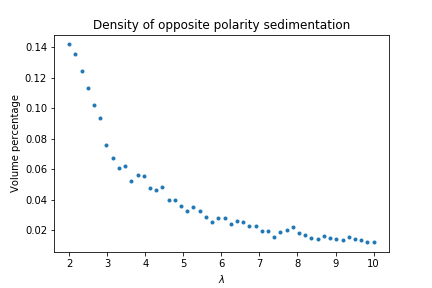

In [114]:
plt.plot(pts, densities, '.')
plt.xlabel("$\lambda$")
plt.ylabel("Volume percentage")
plt.title("Density of opposite polarity sedimentation")
plt.savefig('vol_lambda', dpi = 800)
plt.show()

In [6]:
heights = []
for n in np.arange(100, 1000, 100):
    p = go(n, 2, 100)
    cnt = p[:,2] > 19 and p[:,2] < 21
plt.scatter(np.arange(100, 1000, 100), heights)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [7]:
def dropBall(N, dim, R, dune = False):
    
    H = np.pad(np.zeros([dim,dim]), 1, 'constant', constant_values=1000)
    EF = np.pad(np.zeros([dim-2*(R-1),dim-2*(R-1)]), (R,R), 'linear_ramp', end_values=(10000, 10000))
    
    # Drop N balls
    for i in range(N):
        if dune:
            pos = ((dim + 1) // 2, (dim + 1) // 2)
        else:
            pos = tuple(np.random.randint(1, dim-1, size = 2))        # Generate random x,y coordinates
        neighbors = EF[pos[0] - 1:pos[0] + 2,pos[1] - 1:pos[1] + 2]   # 9 adjacent locations
        local_min = np.min(neighbors)                                 # minimum potential in neighborhood

        
        # Loop to update position of particle as it follows the potential gradient
        while neighbors[1,1] != local_min:
            mins = np.array(np.where(neighbors==local_min)).transpose() - 1
            relative_new_pt = mins[np.random.randint(0,len(mins))]
            pos = (pos[0] + relative_new_pt[0], pos[1] + relative_new_pt[1]) # New position of particle
            neighbors = EF[pos[0] - 1:pos[0] + 2,pos[1] - 1:pos[1] + 2]
            local_min = np.min(neighbors)
            
        z = EF[pos]
        h = H[pos]
        for i in range(math.ceil(pos[0] - R), math.floor(pos[0] + R + 1)):
            for j in range(math.ceil(pos[1] - R), math.floor(pos[1] + R + 1)):
                if j in range(dim + 2) and i in range(dim+ 2):
                    sq_dist = (pos[0] - i) ** 2 + (pos[1] - j) ** 2
                    if  sq_dist <= R ** 2:
                        new_height = h + R + (R ** 2 - (i - pos[0]) ** 2 - (j - pos[1]) ** 2) ** .5
                        H[i, j] = new_height
                        
        for i in range(math.ceil(pos[0] - 2 * R), math.floor(pos[0] + 2 * R + 1)):
            for j in range(math.ceil(pos[1] - 2 * R), math.floor(pos[1] + 2 * R + 1)):
                if j in range(dim+2) and i in range(dim+2):
                    sq_dist = (pos[0] - i) ** 2 + (pos[1] - j) ** 2
                    if  sq_dist <= (2 * R) ** 2:
                        current_p = EF[i, j]
                        b = (2 * R) ** 2 - sq_dist
                        new_p = b ** 0.5 + (z - R)
                        EF[i, j] = max(current_p, new_p)
                    
    return H[1:-1,1:-1] # Remove padding
            
        
        

# Find mean volume fraction for sedimentation with sliding 

In [76]:
fracs = []
#for i in range(100):        # Very slow, ran on maniac 

    dim = 120
    R = 8
    N = 300

    b = dropBall(N, dim, R)
    frac = N*(4/3)*np.pi*R**3 / (np.max(b) * dim **2)
    print('Volume fraction: {}'.format(frac))
    fracs.append(frac)
    
mvf = np.mean(fracs)
print('Mean volume fraction: {}'.format(mvf))

Volume fraction: 0.6007944134258454
Volume fraction: 0.6180311924566484
Volume fraction: 0.6645551477807697
Mean volume fraction: 0.6277935845544212


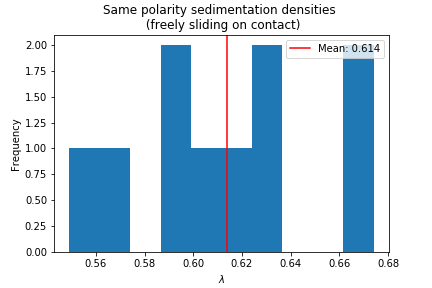

In [75]:
plt.hist(fracs)
plt.axvline(np.mean(fracs), color='red', linewidth=1.5, label='Mean: {}'.format(round(np.mean(fracs), 3)))
plt.legend(loc='upper right')
plt.xlabel("$\lambda$")
plt.ylabel("Frequency")
plt.title("Same polarity sedimentation densities \n (freely sliding on contact)")
plt.savefig('same_pol_dens')
plt.show()

# Angle of Repose

Now we apply the sedimentation model to study the maximum angle of repose for uniform shperical sedimentation without slipping (i.e. sticky sand). 

In [34]:
a = dropBall(10000, 280, 4, dune = True)

In [35]:
h = np.max(a)                           # Max height of sand
m = a[140,:] != 0
w = sum(m) / 2                          # Horiz distance from edge to center

angle = np.arctan(h/w) * 180/np.pi      # Angle of Repose in Degrees
angle

48.47858491622886

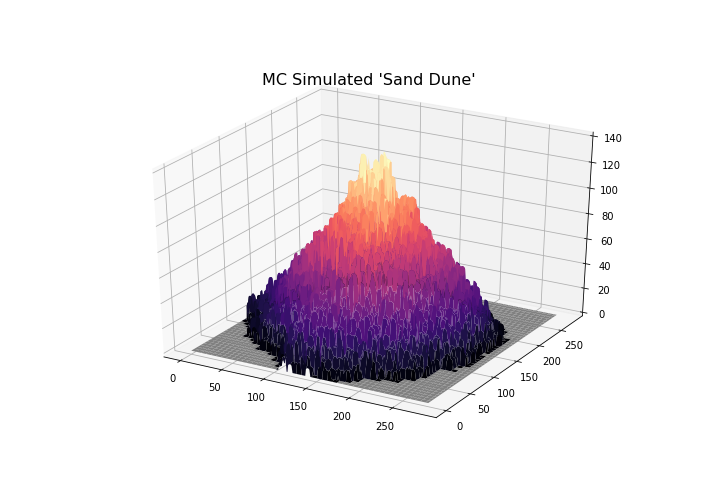

In [121]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

X = np.arange(0, 280)
Y = np.arange(0, 280)
X, Y = np.meshgrid(X, Y)
a = np.ma.masked_where(a == 0, a)

colors = plt.cm.magma
colors.set_under(color='gray', alpha = 1)    
ax.plot_surface(X, Y, a, cmap=colors, vmin=.1)
plt.title("MC Simulated 'Sand Dune'", fontsize = 16)
ax.set_zlim(0,140)
plt.savefig('dune', dpi = 800)

In [94]:
a.data[100,100]

62.399486514937564

In [294]:
np.random.choice(range(len(mins)))

0

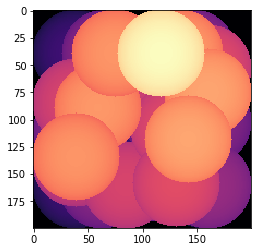

In [21]:
plt.clf()
plt.imshow(b, cmap='magma')
plt.show()

In [44]:
np.arctan(26/34)*180/np.pi

37.40535663140856

In [63]:
np.arctan(148/127)*180/np.pi

49.36683896255653